<a href="https://colab.research.google.com/github/aoctavia/Self-Supervised-Pretraining-Multi-Task-Segmentation-Classification/blob/main/Self_Supervised_Pretraining_%2B_Multi_Task_Segmentation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gambaran arsitektur & alur
1. Self‑supervised pretraining (SSL) di semua gambar (tanpa label) → encoder kuat

2. Fine‑tune classifier (tumor vs no tumor → lalu 4 kelas)

3. Generate CAM dari classifier → pseudo‑mask

4. Train segmentation head (UNet‑style decoder) dengan Dice + BCE pakai pseudo‑mask

5. Joint training (shared encoder) dengan loss gabungan:

$$
\mathscr{L} = \lambda_{\mathrm{cls}} \cdot \mathrm{CE} + \lambda_{\mathrm{seg}} \cdot (\mathrm{Dice} + \mathrm{BCE})
$$


6. Robustness: augmentasi berbasis fisika MRI (noise, motion blur, bias‑field) + evaluasi

### 1) Setup & Mount Drive

In [1]:
# Colab: Runtime -> Change runtime type -> GPU (T4/L4/A100)
!nvidia-smi

!pip -q install timm==1.0.3 torchmetrics==1.4.0 albumentations==1.4.7 einops==0.8.0 grad-cam==1.5.0
!pip -q install lightning==2.4.0  # opsional, kalau mau pakai PyTorch Lightning

from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain"  # ganti sesuai folder dataset
WORK_DIR = "/content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project"

!mkdir -p "{WORK_DIR}/checkpoints" "{WORK_DIR}/pseudo_masks" "{WORK_DIR}/logs"

Wed Aug 13 12:32:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2) Konfigurasi  & Util

In [2]:
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

IMG_EXTS = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

def find_split_dir(root, split_kind="train"):
    cands = ["Training","Train","training","train"] if split_kind=="train" else ["Testing","Test","testing","test"]
    for c in cands:
        d = os.path.join(root, c)
        if os.path.isdir(d):
            return d
    return None

def detect_classes(dir_path):
    return sorted([d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))])

def list_images_in_dir(dir_path, classes, recursive=False):
    items = []
    for c in classes:
        cls_dir = os.path.join(dir_path, c)
        if not os.path.isdir(cls_dir):
            alts = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,d)) and d.lower()==c.lower()]
            if alts:
                cls_dir = os.path.join(dir_path, alts[0])
            else:
                print(f"WARNING: folder kelas tidak ada: {cls_dir}")
                continue
        pattern = "**/*" if recursive else "*"
        files = []
        for ext in IMG_EXTS:
            files.extend(glob.glob(os.path.join(cls_dir, pattern + ext), recursive=recursive))
        if len(files)==0 and not recursive:
            for ext in IMG_EXTS:
                files.extend(glob.glob(os.path.join(cls_dir, "**", "*" + ext), recursive=True))
        if len(files)==0:
            print(f"WARNING: tidak ada file gambar di {cls_dir}")
        items.extend((p, c) for p in files)
    return items

def build_items(DATA_DIR):
    train_dir = find_split_dir(DATA_DIR, "train")
    test_dir  = find_split_dir(DATA_DIR, "test")
    if train_dir and test_dir:
        classes = detect_classes(train_dir)
        train_items = list_images_in_dir(train_dir, classes)
        test_items  = list_images_in_dir(test_dir,  classes)
        return train_items, test_items, classes, "pre-split"

    classes = detect_classes(DATA_DIR)
    if classes:
        all_items = list_images_in_dir(DATA_DIR, classes)
        y_all = [c for _, c in all_items]
        X = [p for p,_ in all_items]
        cls2idx = {c:i for i,c in enumerate(sorted(set(y_all)))}
        y_idx = np.array([cls2idx[c] for c in y_all])

        X_train, X_tmp, y_train, y_tmp = train_test_split(X, y_idx, test_size=0.30, random_state=42, stratify=y_idx)
        X_val,   X_test, y_val,  y_test= train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

        train_items = list(zip(X_train, [list(cls2idx.keys())[list(cls2idx.values()).index(y)] for y in y_train]))
        val_items   = list(zip(X_val,   [list(cls2idx.keys())[list(cls2idx.values()).index(y)] for y in y_val]))
        test_items  = list(zip(X_test,  [list(cls2idx.keys())[list(cls2idx.values()).index(y)] for y in y_test]))
        return (train_items, test_items, classes, "no-split", val_items)

    raise FileNotFoundError("Tidak menemukan struktur dataset di DATA_DIR.")

built = build_items(DATA_DIR)

if built[3] == "pre-split":
    train_items, test_items, CLASSES, _ = built
    CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}
    train_paths = [(p, CLASS2IDX[y]) for p,y in train_items]

    y_all = np.array([y for _,y in train_paths])
    can_stratify = all((y_all==k).sum() >= 2 for k in np.unique(y_all))
    if can_stratify and len(train_paths) >= 10:
        train_paths, val_paths = train_test_split(train_paths, test_size=0.15, random_state=42, stratify=y_all)
    else:
        print("NOTE: stratify OFF (kelas terlalu sedikit/dataset kecil).")
        train_paths, val_paths = train_test_split(train_paths, test_size=max(1, int(0.15*len(train_paths))), random_state=42, shuffle=True)
    test_paths  = [(p, CLASS2IDX[y]) for p,y in test_items]

else:
    train_items, test_items, CLASSES, _, val_items = built
    CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}
    train_paths = [(p, CLASS2IDX[y]) for p,y in train_items]
    val_paths   = [(p, CLASS2IDX[y]) for p,y in val_items]
    test_paths  = [(p, CLASS2IDX[y]) for p,y in test_items]

print("Classes:", CLASSES)
print("Counts -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Counts -> train: 4855 val: 857 test: 1311


#### cell diagnostik

In [4]:
import os, glob
print("DATA_DIR:", DATA_DIR)
print("Ada folder ini? TRAIN:", os.path.isdir(os.path.join(DATA_DIR, "Training")),
      "TEST:", os.path.isdir(os.path.join(DATA_DIR, "Testing")))

# Tunjukkan kelas yang terdeteksi di training split
train_dir = None
for d in ["Training","Train","training","train"]:
    if os.path.isdir(os.path.join(DATA_DIR, d)):
        train_dir = os.path.join(DATA_DIR, d); break
print("Training dir:", train_dir)
if train_dir:
    print("Subfolder kelas di Training dir:", [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir,d))])

# Hitung file yang cocok ekstensi
IMG_EXTS = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
if train_dir:
    total = 0
    for cls in os.listdir(train_dir):
        cls_dir = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        cnt = 0
        for ext in IMG_EXTS:
            cnt += len(glob.glob(os.path.join(cls_dir, f"*{ext}")))
            cnt += len(glob.glob(os.path.join(cls_dir, "**", f"*{ext}"), recursive=True))
        print(f"- {cls}: {cnt} files")
        total += cnt
    print("Total files in Training:", total)

# Sanity: cetak 3 contoh path dari train_paths/val_paths/test_paths
try:
    print("len(train_paths), len(val_paths), len(test_paths):", len(train_paths), len(val_paths), len(test_paths))
    print("sample train:", train_paths[0][0] if len(train_paths)>0 else "EMPTY")
    print("sample val  :", val_paths[0][0]   if len(val_paths)>0   else "EMPTY")
    print("sample test :", test_paths[0][0]  if len(test_paths)>0  else "EMPTY")
except NameError as e:
    print("Variable belum ada (jalankan Step-2 dulu).", e)


DATA_DIR: /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain
Ada folder ini? TRAIN: True TEST: True
Training dir: /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain/Training
Subfolder kelas di Training dir: ['meningioma', 'glioma', 'pituitary', 'notumor']
- meningioma: 2678 files
- glioma: 2642 files
- pituitary: 2914 files
- notumor: 3190 files
Total files in Training: 11424
len(train_paths), len(val_paths), len(test_paths): 4855 857 1311
sample train: /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain/Training/glioma/Tr-gl_0798.jpg
sample val  : /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain/Training/notumor/Tr-no_1186.jpg
sample test : /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain/Testing/glioma/Te-glTr_0001.jpg


In [5]:
# Pakai CLASS2IDX dari Step-2
IDX2CLASS = {v:k for k,v in CLASS2IDX.items()}

DISPLAY_MAP = {
    "pituitary": "pituitary_tumor",
    "notumor": "no_tumor",
    "glioma": "glioma",
    "meningioma": "meningioma",
}

def display_name(idx: int) -> str:
    raw = IDX2CLASS[idx]
    return DISPLAY_MAP.get(raw, raw)


In [ ]:
target_names = [display_name(i) for i in range(len(CLASS2IDX))]


### 3) Dataset loader (supervised & SSL)

In [6]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import albumentations.pytorch

IMG_SIZE   = 224
BATCH_SSL  = 128
BATCH_SUP  = 32
NUM_WORKERS = 4

aug_train = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, border_mode=0, p=0.7),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.ImageCompression(quality_lower=85, p=0.3),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2(),
])

aug_val = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2(),
])

class SupervisedMRIDataset(Dataset):
    def __init__(self, items, aug):
        self.items = items
        self.aug = aug
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        img = np.array(Image.open(path).convert("RGB"))
        img = self.aug(image=img)["image"]
        return img, y, path

ssl_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.5, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.5),
    A.MotionBlur(5, p=0.3),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2(),
])

class SSLDataset(Dataset):
    def __init__(self, items, aug):
        self.paths = [p for p,_ in items]
        self.aug = aug
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        path = self.paths[i]
        img  = np.array(Image.open(path).convert("RGB"))
        v1 = self.aug(image=img)["image"]
        v2 = self.aug(image=img)["image"]
        return v1, v2

# gunakan train_paths, val_paths, test_paths dari Step-2
sup_tr = SupervisedMRIDataset(train_paths, aug_train)
sup_va = SupervisedMRIDataset(val_paths,   aug_val)
sup_te = SupervisedMRIDataset(test_paths,  aug_val)

tr_dl = DataLoader(sup_tr, batch_size=BATCH_SUP, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
va_dl = DataLoader(sup_va, batch_size=BATCH_SUP, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
te_dl = DataLoader(sup_te, batch_size=BATCH_SUP, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

ssl_items = train_paths + val_paths + test_paths
ssl_ds = SSLDataset(ssl_items, ssl_aug)
ssl_dl = DataLoader(ssl_ds, batch_size=BATCH_SSL, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# sanity check
xb, yb, pb = next(iter(tr_dl))
print("Supervised batch:", xb.shape, "labels raw:", yb[:5].tolist(), "labels pretty:", [display_name(int(i)) for i in yb[:5]])
v1, v2 = next(iter(ssl_dl))
print("SSL batch:", v1.shape, v2.shape)


Supervised batch: torch.Size([32, 3, 224, 224]) labels raw: [0, 2, 0, 0, 0] labels pretty: ['glioma', 'no_tumor', 'glioma', 'glioma', 'glioma']
SSL batch: torch.Size([128, 3, 224, 224]) torch.Size([128, 3, 224, 224])


### 4) Self‑Supervised Pretraining (SimCLR sederhana)

#### kode dibawah ini akan crash jika memakai colabs free ! JANGAN DI RUN JIKA PAKAI FREE MODE !

In [ ]:
# # ==== Step-4: SSL Pretraining (SimCLR) ====
# import copy, torch, torch.nn as nn, torch.nn.functional as F
# import timm

# # (opsional) ubah num_workers agar aman di Colab
# NUM_WORKERS = 2

# class ProjectionHead(nn.Module):
#     def __init__(self, in_dim, hid=2048, out_dim=128):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(in_dim, hid), nn.ReLU(inplace=True),
#             nn.Linear(hid, out_dim)
#         )
#     def forward(self, x): return self.net(x)

# class SimCLR(nn.Module):
#     def __init__(self, encoder_name="resnet50", proj_out=128):
#         super().__init__()
#         self.encoder = timm.create_model(encoder_name, pretrained=False, num_classes=0)  # feature vector
#         in_dim = self.encoder.num_features
#         self.proj = ProjectionHead(in_dim, 2048, proj_out)
#     def forward(self, x):
#         h = self.encoder(x)
#         z = F.normalize(self.proj(h), dim=1)
#         return h, z

# def info_nce(z1, z2, tau=0.2):
#     N = z1.size(0)
#     z1 = F.normalize(z1, dim=1); z2 = F.normalize(z2, dim=1)
#     reps = torch.cat([z1, z2], dim=0)         # (2N, d)
#     sim  = reps @ reps.T                      # cosine (karena sudah normalized)
#     labels = torch.cat([torch.arange(N), torch.arange(N)], dim=0).to(z1.device)
#     labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
#     mask = torch.eye(labels.shape[0], dtype=torch.bool, device=z1.device)
#     labels = labels[~mask].view(labels.shape[0], -1)
#     sim    = sim[~mask].view(sim.shape[0], -1)
#     pos    = sim[labels.bool()].view(labels.shape[0], -1)
#     neg    = sim[~labels.bool()].view(labels.shape[0], -1)
#     logits = torch.cat([pos, neg], dim=1) / tau
#     y = torch.zeros(logits.size(0), dtype=torch.long, device=z1.device)
#     return F.cross_entropy(logits, y)

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# EPOCH_SSL = 10        # mulai rendah dulu; nanti bisa ditingkatkan (20–50)

# simclr = SimCLR("resnet50").to(DEVICE)
# opt_ssl = torch.optim.AdamW(simclr.parameters(), lr=1e-3, weight_decay=1e-4)

# for epoch in range(EPOCH_SSL):
#     simclr.train()
#     total = 0
#     for v1, v2 in ssl_dl:                 # dari Step-3
#         v1, v2 = v1.to(DEVICE), v2.to(DEVICE)
#         _, z1 = simclr(v1)
#         _, z2 = simclr(v2)
#         loss = info_nce(z1, z2, tau=0.2)
#         opt_ssl.zero_grad(); loss.backward(); opt_ssl.step()
#         total += loss.item()*v1.size(0)
#     print(f"[SSL] epoch {epoch+1}/{EPOCH_SSL} loss={total/len(ssl_ds):.4f}")

# # simpan encoder hasil pretraining
# ssl_encoder = copy.deepcopy(simclr.encoder).eval().to(DEVICE)
# enc_path = f"{WORK_DIR}/checkpoints/ssl_encoder_resnet50.pt"
# torch.save(ssl_encoder.state_dict(), enc_path)
# print("Saved:", enc_path)


#### Opsi A — “Safe Mode” SimCLR (lebih ringan, tetap SimCLR)

In [7]:
# ---- TUNE AGAR HEMAT MEMORI ----
NUM_WORKERS   = 2          # kurangi worker
BATCH_SSL     = 32         # TURUNKAN dari 128 -> 32 (atau 16 kalau masih crash)
IMG_SIZE      = 192        # 224 -> 192 (atau 160 kalau perlu)
EPOCH_SSL     = 5          # mulai kecil dulu, bisa ulang beberapa kali

# 1) pakai subset data untuk SSL (mis. 15k sampel)
from torch.utils.data import Subset
import numpy as np, math

max_ssl_samples = 15000      # turunkan lagi bila perlu (8000/4000)
all_idx = np.arange(len(ssl_ds))
np.random.shuffle(all_idx)
ssl_subset_idx = all_idx[:min(max_ssl_samples, len(ssl_ds))]
ssl_dl = DataLoader(
    Subset(ssl_ds, ssl_subset_idx),
    batch_size=BATCH_SSL, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=False,  # pin_memory False mengurangi crash di Colab
    persistent_workers=False, prefetch_factor=2
)

# 2) ganti encoder lebih kecil (resnet18) biar ringan
import timm, torch, torch.nn as nn, torch.nn.functional as F, copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hid=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(inplace=True),
            nn.Linear(hid, out_dim)
        )
    def forward(self, x): return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, encoder_name="resnet18", proj_out=128):
        super().__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=False, num_classes=0)
        self.in_dim = self.encoder.num_features
        self.proj = ProjectionHead(self.in_dim, 512, proj_out)
    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.proj(h), dim=1)
        return h, z

def info_nce(z1, z2, tau=0.2):
    N = z1.size(0)
    z1 = F.normalize(z1, dim=1); z2 = F.normalize(z2, dim=1)
    reps = torch.cat([z1, z2], dim=0)   # (2N,d)
    sim  = reps @ reps.T                # cosine (sudah norm)
    labels = torch.arange(N, device=z1.device)
    labels = torch.cat([labels, labels], dim=0)
    pos_mask = (labels.unsqueeze(0)==labels.unsqueeze(1)).float()
    mask = torch.eye(pos_mask.shape[0], dtype=torch.bool, device=z1.device)
    pos = sim[pos_mask.bool()].view(pos_mask.shape[0], -1)
    neg = sim[~pos_mask.bool()].view(pos_mask.shape[0], -1)
    logits = torch.cat([pos, neg], dim=1) / tau
    y = torch.zeros(logits.size(0), dtype=torch.long, device=z1.device)
    return F.cross_entropy(logits, y)

# 3) mixed precision + gradient accumulation
from torch.cuda.amp import autocast, GradScaler
accumulate_steps = 2  # simulasikan batch lebih besar tanpa OOM

simclr = SimCLR("resnet18").to(DEVICE)
opt_ssl = torch.optim.AdamW(simclr.parameters(), lr=8e-4, weight_decay=1e-4)
scaler = GradScaler(enabled=(DEVICE=="cuda"))

# optional: kurangi fragmentasi memori
import os, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

for epoch in range(EPOCH_SSL):
    simclr.train()
    running, nimg, step = 0.0, 0, 0
    opt_ssl.zero_grad(set_to_none=True)

    for v1, v2 in ssl_dl:
        v1, v2 = v1.to(DEVICE, non_blocking=True), v2.to(DEVICE, non_blocking=True)
        with autocast(enabled=(DEVICE=="cuda")):
            _, z1 = simclr(v1)
            _, z2 = simclr(v2)
            loss = info_nce(z1, z2, tau=0.2) / accumulate_steps

        scaler.scale(loss).backward()
        step += 1
        if step % accumulate_steps == 0:
            scaler.step(opt_ssl)
            scaler.update()
            opt_ssl.zero_grad(set_to_none=True)

        running += loss.item()*accumulate_steps*v1.size(0)
        nimg += v1.size(0)

        # flush cache sesekali
        if DEVICE=="cuda" and (step % 50 == 0):
            torch.cuda.empty_cache()

    print(f"[SSL] epoch {epoch+1}/{EPOCH_SSL} loss={running/max(1,nimg):.4f}")

# simpan encoder
ssl_encoder = copy.deepcopy(simclr.encoder).eval().to(DEVICE)
enc_path = f"{WORK_DIR}/checkpoints/ssl_encoder_resnet18.pt"
torch.save(ssl_encoder.state_dict(), enc_path)
print("Saved:", enc_path)


/tmp/ipython-input-3613165050.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-3613165050.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):


[SSL] epoch 1/5 loss=2.3234
[SSL] epoch 2/5 loss=1.7254
[SSL] epoch 3/5 loss=1.5008
[SSL] epoch 4/5 loss=1.3826
[SSL] epoch 5/5 loss=1.3018
Saved: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/ssl_encoder_resnet18.pt


#### Opsi B — Ganti ke SimSiam (lebih ramah batch kecil)
SimSiam tidak butuh negative pairs → jauh lebih stabil di batch kecil (16–32). Kalau mau, kamu bisa langsung pakai SimSiam ketimbang SimCLR. (Aku bisa kasih blok kode SimSiam siap tempel juga.)

### 5) Fine‑tune classifier (4 kelas)

In [8]:
import torch, torch.nn as nn, torch.nn.functional as F
import timm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASS2IDX)
enc_path = f"{WORK_DIR}/checkpoints/ssl_encoder_resnet18.pt"  # dari step-4

# (opsional) pretty names
IDX2CLASS = {v:k for k,v in CLASS2IDX.items()}
DISPLAY_MAP = {"pituitary":"pituitary_tumor", "notumor":"no_tumor"}
def display_name(i):
    raw = IDX2CLASS[i];
    return DISPLAY_MAP.get(raw, raw)

class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        in_dim = self.encoder.num_features
        self.cls = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        feat = self.encoder(x)
        logits = self.cls(feat)
        return logits, feat

# load encoder SSL (resnet18)
encoder_ft = timm.create_model("resnet18", pretrained=False, num_classes=0)
encoder_ft.load_state_dict(torch.load(enc_path, map_location="cpu"))
model_cls = Classifier(encoder_ft, NUM_CLASSES).to(DEVICE)

opt = torch.optim.AdamW(model_cls.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def run_epoch(dl, train=True):
    model_cls.train(train)
    tot, corr, n = 0.0, 0, 0
    for x,y,_ in dl:
        x = x.to(DEVICE); y = torch.as_tensor(y, device=DEVICE)
        logits,_ = model_cls(x)
        loss = criterion(logits, y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
        corr += (logits.argmax(1)==y).sum().item()
        n += x.size(0)
    return tot/n, corr/n

EPOCH_CLS = 8  # bisa tambah setelah jalan stabil
for ep in range(EPOCH_CLS):
    tr_l,tr_a = run_epoch(tr_dl, True)
    va_l,va_a = run_epoch(va_dl, False)
    print(f"[CLS] {ep+1}/{EPOCH_CLS}  train {tr_l:.4f}/{tr_a:.3f}  val {va_l:.4f}/{va_a:.3f}")

# evaluasi test
model_cls.eval()
all_y, all_p = [], []
with torch.no_grad():
    for x,y,_ in te_dl:
        x = x.to(DEVICE)
        probs = F.softmax(model_cls(x)[0], dim=1).cpu().numpy()
        all_p.append(probs); all_y.extend(y)
all_p = np.vstack(all_p)
pred = all_p.argmax(1)

target_names = [display_name(i) for i in range(NUM_CLASSES)]
print(classification_report(all_y, pred, target_names=target_names, digits=4))
print(confusion_matrix(all_y, pred))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[CLS] 1/8  train 0.8573/0.699  val 0.6195/0.776
[CLS] 2/8  train 0.5262/0.819  val 0.3974/0.861
[CLS] 3/8  train 0.4385/0.844  val 0.4716/0.826
[CLS] 4/8  train 0.4024/0.856  val 0.3250/0.869
[CLS] 5/8  train 0.3670/0.865  val 0.2715/0.897
[CLS] 6/8  train 0.3362/0.880  val 0.2563/0.904
[CLS] 7/8  train 0.3136/0.888  val 0.2367/0.911
[CLS] 8/8  train 0.2958/0.894  val 0.2414/0.907
                 precision    recall  f1-score   support

         glioma     0.8384    0.9167    0.8758       300
     meningioma     0.8667    0.6797    0.7619       306
       no_tumor     0.9076    0.9704    0.9379       405
pituitary_tumor     0.9097    0.9400    0.9246       300

       accuracy                         0.8833      1311
      macro avg     0.8806    0.8767    0.8751      1311
   weighted avg     0.8827    0.8833    0.8796      1311

[[275  25   0   0]
 [ 31 208  40  27]
 [  5   6 393   1]
 [ 17   1   0 282]]


### 6) Generate pseudo‑mask via Grad‑CAM

In [10]:
# ==== Step-6 (fixed): Grad-CAM -> pseudo-mask ====
!pip -q install grad-cam==1.5.0

import os, numpy as np, torch
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_cls.eval()  # eval mode, tapi JANGAN pakai torch.no_grad() saat CAM

# Kelas tumor (exclude no_tumor/notumor)
tumor_class_names = [k for k in CLASS2IDX.keys() if k.lower() not in ["no_tumor","notumor"]]
tumor_class_idx = set(CLASS2IDX[k] for k in tumor_class_names)

# Target layer utk ResNet18
target_layer = model_cls.encoder.layer4[-1]

os.makedirs(f"{WORK_DIR}/pseudo_masks", exist_ok=True)

def tensor_to_img01(t):
    x = t.permute(1,2,0).detach().cpu().numpy()
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x

def save_mask_for_batch(x, paths):
    # x: [B,3,H,W] on DEVICE
    # Prediksi dulu utk ambil target kelas
    logits, _ = model_cls(x)
    preds = logits.argmax(1).detach().cpu().numpy()

    # Grad-CAM perlu gradient -> JANGAN pakai no_grad di sini
    with GradCAM(model=model_cls, target_layers=[target_layer]) as cam:
        for i, path in enumerate(paths):
            if int(preds[i]) not in tumor_class_idx:
                continue
            targets = [ClassifierOutputTarget(int(preds[i]))]
            heatmap = cam(input_tensor=x[i].unsqueeze(0), targets=targets)[0]  # [H,W] in [0,1]

            # Threshold konservatif jadi pseudo-mask biner
            thr = np.percentile(heatmap, 75.0)
            mask = (heatmap >= thr).astype(np.uint8) * 255

            out_path = path.replace(DATA_DIR, WORK_DIR + "/pseudo_masks")
            out_path = os.path.splitext(out_path)[0] + "_mask.png"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            Image.fromarray(mask).save(out_path)

# Proses training set dalam batch kecil biar hemat memori
for xb, yb, pb in tr_dl:
    xb = xb.to(DEVICE, non_blocking=True)
    save_mask_for_batch(xb, pb)
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

print("Pseudo-masks saved under:", WORK_DIR + "/pseudo_masks")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Pseudo-masks saved under: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/pseudo_masks


### 7) Model Multi‑Task (shared encoder + UNet‑decoder + classifier head)

#### 7a) (Opsional) buat pseudo‑mask juga untuk validation
Supaya bisa hitung Dice di val set.

In [11]:
# === Generate pseudo-mask untuk VAL set (opsional tapi disarankan) ===
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import os, numpy as np, torch
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_cls.eval()
target_layer = model_cls.encoder.layer4[-1]
tumor_class_names = [k for k in CLASS2IDX.keys() if k.lower() not in ["no_tumor","notumor"]]
tumor_class_idx = set(CLASS2IDX[k] for k in tumor_class_names)

def save_mask_for_batch(x, paths):
    logits,_ = model_cls(x)
    preds = logits.argmax(1).detach().cpu().numpy()
    with GradCAM(model=model_cls, target_layers=[target_layer]) as cam:
        for i, path in enumerate(paths):
            if int(preds[i]) not in tumor_class_idx:
                continue
            heatmap = cam(input_tensor=x[i].unsqueeze(0), targets=[ClassifierOutputTarget(int(preds[i]))])[0]
            thr = np.percentile(heatmap, 75.0)
            mask = (heatmap >= thr).astype(np.uint8) * 255
            out_path = path.replace(DATA_DIR, WORK_DIR + "/pseudo_masks")
            out_path = os.path.splitext(out_path)[0] + "_mask.png"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            Image.fromarray(mask).save(out_path)

for xb, yb, pb in va_dl:
    xb = xb.to(DEVICE, non_blocking=True)
    save_mask_for_batch(xb, pb)
    if DEVICE=="cuda":
        torch.cuda.empty_cache()

print("Val pseudo-masks saved under:", WORK_DIR + "/pseudo_masks")


Val pseudo-masks saved under: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/pseudo_masks


#### 7b) Dataset untuk joint training (pakai pseudo‑mask)

In [15]:
# ==== Step-7b (fixed): Dataset untuk Multi-Task ====
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
import albumentations.pytorch

# Pakai ukuran yang sama dengan training klasifikasi
IMG_SIZE_MT = IMG_SIZE if "IMG_SIZE" in globals() else 224
NUM_WORKERS = 2  # sesuai saran Colab

# Augmentasi gambar (sama dengan aug_train/aug_val yang sudah ada)
# Kita pakai aug_train & aug_val dari Step-3
aug_mask_resize = A.Compose([
    A.Resize(IMG_SIZE_MT, IMG_SIZE_MT),
    albumentations.pytorch.ToTensorV2()
])

def load_pseudo_mask(path: str):
    """Load pseudo-mask (0/1). Jika tidak ada, kembalikan mask nol ukuran IMG_SIZE_MT."""
    mpath = path.replace(DATA_DIR, WORK_DIR + "/pseudo_masks")
    mpath = os.path.splitext(mpath)[0] + "_mask.png"
    if os.path.exists(mpath):
        m = np.array(Image.open(mpath).convert("L"))  # HxW uint8
        m = (m > 127).astype(np.float32)             # 0/1 float
    else:
        m = np.zeros((IMG_SIZE_MT, IMG_SIZE_MT), dtype=np.float32)
    # pastikan ukuran konsisten
    if m.shape != (IMG_SIZE_MT, IMG_SIZE_MT):
        m = np.array(Image.fromarray((m*255).astype(np.uint8)).resize((IMG_SIZE_MT, IMG_SIZE_MT), resample=Image.NEAREST)) / 255.0
    return m

class SegSupDataset(Dataset):
    def __init__(self, items, aug_img):
        self.items = items
        self.aug_img = aug_img
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, y = self.items[i]
        img = np.array(Image.open(path).convert("RGB"))                  # HxWx3
        m   = load_pseudo_mask(path)                                     # HxW (float32, 0..1)

        img_t = self.aug_img(image=img)["image"]                         # [3,H,W]
        m_t   = torch.from_numpy(m).unsqueeze(0).float()                 # [1,H,W]  <<< FIX: tanpa dimensi ekstra

        return img_t, y, m_t, path

# Dataloader
seg_tr = SegSupDataset(train_paths, aug_train)
seg_va = SegSupDataset(val_paths,   aug_val)

seg_tr_dl = DataLoader(seg_tr, batch_size=32, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
seg_va_dl = DataLoader(seg_va, batch_size=32, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Seg loaders -> train:", len(seg_tr_dl), "val:", len(seg_va_dl))


Seg loaders -> train: 152 val: 27


#### 7c) Arsitektur Multi‑Task (ResNet18 features + UNet‑decoder)

In [16]:
# ==== Model Multi-Task (ResNet18 backbone) ====
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class ResNet18Features(nn.Module):
    def __init__(self):
        super().__init__()
        m = torchvision.models.resnet18(weights=None)
        self.conv1=m.conv1; self.bn1=m.bn1; self.relu=m.relu; self.maxpool=m.maxpool
        self.layer1=m.layer1; self.layer2=m.layer2; self.layer3=m.layer3; self.layer4=m.layer4
        self.out_dim = 512
    def forward(self,x):
        x = self.conv1(x); x=self.bn1(x); x=self.relu(x); c1=self.maxpool(x)  # 1/4
        c2=self.layer1(c1)   # 1/4
        c3=self.layer2(c2)   # 1/8
        c4=self.layer3(c3)   # 1/16
        c5=self.layer4(c4)   # 1/32
        emb = torch.flatten(F.adaptive_avg_pool2d(c5,1),1)
        return [c2,c3,c4,c5], emb

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c,out_c,3,1,1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,3,1,1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.net(x)

class UNetDecoder18(nn.Module):
    def __init__(self):
        super().__init__()
        # resnet18: c2=64, c3=128, c4=256, c5=512
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.cb3 = ConvBlock(256+256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.cb2 = ConvBlock(128+128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.cb1 = ConvBlock(64+64, 64)
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.out = nn.Conv2d(32, 1, 1)
    def forward(self, feats):
        c2,c3,c4,c5 = feats
        x = self.up3(c5); x = torch.cat([x,c4],1); x = self.cb3(x)
        x = self.up2(x);  x = torch.cat([x,c3],1); x = self.cb2(x)
        x = self.up1(x);  x = torch.cat([x,c2],1); x = self.cb1(x)
        x = self.up0(x);  x = self.out(x)
        return x

class MultiTaskNet(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.decoder = UNetDecoder18()
        self.cls_head = nn.Linear(self.encoder.out_dim, num_classes)
    def forward(self,x):
        feats, emb = self.encoder(x)
        seg_logit = self.decoder(feats)   # [B,1,H,W]
        cls_logit = self.cls_head(emb)    # [B,C]
        return cls_logit, seg_logit


#### 7d) Inisialisasi dengan SSL encoder dan training joint loss

In [17]:
# ==== Step-7d (fixed): Joint training (classification + segmentation) ====
import torch, torch.nn as nn, torch.nn.functional as F
from torch.amp import autocast, GradScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASS2IDX)
LAMBDA_CLS, LAMBDA_SEG = 1.0, 1.0
EPOCH_JOINT = 10  # bisa ditambah setelah stabil

# ----- Model: gunakan ResNet18Features & MultiTaskNet dari Step-7c -----
# Jika belum terdefinisi di notebook (mis. setelah restart), jalankan ulang Step-7c terlebih dulu.
assert 'ResNet18Features' in globals() and 'MultiTaskNet' in globals(), "Jalankan Step-7c lebih dulu (definisi model)."

# Muat encoder SSL (resnet18) ke encoder fitur sebisa mungkin
enc_path = f"{WORK_DIR}/checkpoints/ssl_encoder_resnet18.pt"
mt_enc = ResNet18Features()
state_ssl = torch.load(enc_path, map_location="cpu")
mt_enc.load_state_dict({k: v for k, v in state_ssl.items() if k in mt_enc.state_dict()}, strict=False)

mt_model = MultiTaskNet(mt_enc, NUM_CLASSES).to(DEVICE)

# Loss & optimizer
bce = nn.BCEWithLogitsLoss()
ce  = nn.CrossEntropyLoss()
opt_mt = torch.optim.AdamW(mt_model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = GradScaler(device="cuda", enabled=(DEVICE=="cuda"))

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum(dim=(2,3))
    den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def run_epoch_joint(dl, train=True):
    mt_model.train(train)
    tot, n, corr = 0.0, 0, 0
    for x, y, m, _ in dl:
        x = x.to(DEVICE, non_blocking=True)                  # [B,3,H,W]
        y = torch.as_tensor(y, device=DEVICE)                # [B]
        m = m.to(DEVICE)                                     # [B,1,H,W]

        with autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
            cls_log, seg_log = mt_model(x)                   # seg_log: [B,1,h,w]
            # >>> Samakan ukuran mask dengan output decoder <<<
            if m.shape[-2:] != seg_log.shape[-2:]:
                m = F.interpolate(m, size=seg_log.shape[-2:], mode='nearest')  # [B,1,h,w]

            loss_cls = ce(cls_log, y)
            loss_seg = 0.5*bce(seg_log, m) + 0.5*dice_loss(seg_log, m)
            loss = LAMBDA_CLS*loss_cls + LAMBDA_SEG*loss_seg

        if train:
            scaler.scale(loss).backward()
            scaler.step(opt_mt)
            scaler.update()
            opt_mt.zero_grad(set_to_none=True)

        tot += loss.item() * x.size(0); n += x.size(0)
        corr += (cls_log.argmax(1) == y).sum().item()

    return tot / max(1, n), corr / max(1, n)

for ep in range(EPOCH_JOINT):
    tr_l, tr_a = run_epoch_joint(seg_tr_dl, True)
    va_l, va_a = run_epoch_joint(seg_va_dl, False)
    print(f"[JOINT] {ep+1}/{EPOCH_JOINT}  train {tr_l:.4f}/{tr_a:.3f}  val {va_l:.4f}/{va_a:.3f}")

ckpt_mt = f"{WORK_DIR}/checkpoints/multitask_resnet18.pt"
torch.save(mt_model.state_dict(), ckpt_mt)
print("Saved:", ckpt_mt)


[JOINT] 1/10  train 1.4421/0.708  val 0.9962/0.827
[JOINT] 2/10  train 1.0027/0.817  val 0.8294/0.842
[JOINT] 3/10  train 0.8893/0.843  val 0.7387/0.876
[JOINT] 4/10  train 0.8272/0.858  val 0.6758/0.896
[JOINT] 5/10  train 0.7726/0.881  val 0.6490/0.910
[JOINT] 6/10  train 0.7639/0.881  val 0.6562/0.901
[JOINT] 7/10  train 0.7340/0.890  val 0.5998/0.917
[JOINT] 8/10  train 0.7027/0.900  val 0.5693/0.930
[JOINT] 9/10  train 0.6904/0.900  val 0.5598/0.932
[JOINT] 10/10  train 0.6814/0.908  val 0.5745/0.925
Saved: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/multitask_resnet18.pt


### Step‑8: Evaluasi & Visualisasi.
Blok di bawah ini melakukan:

Evaluasi klasifikasi di test set (pakai head klasifikasi dari model multitask).

Evaluasi segmentasi (Dice) terhadap pseudo‑mask di validation set.

Simpan overlay prediksi mask di atas citra untuk portofolio.



#### Step‑8a — Load model multitask (kalau belum ada di RAM)

In [18]:
# ==== Step-8a: Load model multitask (opsional kalau kernel baru) ====
import torch, torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
ckpt_mt = f"{WORK_DIR}/checkpoints/multitask_resnet18.pt"

# Definisi model sama dengan Step-7c
class ResNet18Features(nn.Module):
    def __init__(self):
        super().__init__()
        m = torchvision.models.resnet18(weights=None)
        self.conv1=m.conv1; self.bn1=m.bn1; self.relu=m.relu; self.maxpool=m.maxpool
        self.layer1=m.layer1; self.layer2=m.layer2; self.layer3=m.layer3; self.layer4=m.layer4
        self.out_dim = 512
    def forward(self,x):
        x = self.conv1(x); x=self.bn1(x); x=self.relu(x); c1=self.maxpool(x)
        c2=self.layer1(c1); c3=self.layer2(c2); c4=self.layer3(c3); c5=self.layer4(c4)
        emb = torch.flatten(F.adaptive_avg_pool2d(c5,1),1)
        return [c2,c3,c4,c5], emb

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c,out_c,3,1,1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,3,1,1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.net(x)

class UNetDecoder18(nn.Module):
    def __init__(self):
        super().__init__()
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.cb3 = ConvBlock(256+256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.cb2 = ConvBlock(128+128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.cb1 = ConvBlock(64+64, 64)
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.out = nn.Conv2d(32, 1, 1)
    def forward(self, feats):
        c2,c3,c4,c5 = feats
        x = self.up3(c5); x = torch.cat([x,c4],1); x = self.cb3(x)
        x = self.up2(x);  x = torch.cat([x,c3],1); x = self.cb2(x)
        x = self.up1(x);  x = torch.cat([x,c2],1); x = self.cb1(x)
        x = self.up0(x);  x = self.out(x)
        return x

class MultiTaskNet(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.decoder = UNetDecoder18()
        self.cls_head = nn.Linear(self.encoder.out_dim, num_classes)
    def forward(self,x):
        feats, emb = self.encoder(x)
        seg_logit = self.decoder(feats)
        cls_logit = self.cls_head(emb)
        return cls_logit, seg_logit

NUM_CLASSES = len(CLASS2IDX)
mt_model = MultiTaskNet(ResNet18Features(), NUM_CLASSES).to(DEVICE)
mt_model.load_state_dict(torch.load(ckpt_mt, map_location=DEVICE))
mt_model.eval()
print("Loaded multitask model from:", ckpt_mt)


Loaded multitask model from: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/multitask_resnet18.pt


#### Step‑8b — Evaluasi klasifikasi di Test Set

In [19]:
# ==== Step-8b: Klasifikasi (test set) ====
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

# te_dl dibuat di Step-3 (SupervisedMRIDataset + aug_val)
all_y, all_p = [], []
with torch.no_grad():
    for xb, yb, _ in te_dl:
        xb = xb.to(DEVICE)
        logits, _ = mt_model(xb)     # pakai head klasifikasi dari model multitask
        probs = F.softmax(logits, dim=1).cpu().numpy()
        all_p.append(probs); all_y.extend(yb)

all_p = np.vstack(all_p)
pred = all_p.argmax(1)

# pretty names (opsional)
try:
    target_names = [display_name(i) for i in range(NUM_CLASSES)]
except:
    IDX2CLASS = {v:k for k,v in CLASS2IDX.items()}
    target_names = [IDX2CLASS[i] for i in range(NUM_CLASSES)]

print(classification_report(all_y, pred, target_names=target_names, digits=4))
print(confusion_matrix(all_y, pred))


                 precision    recall  f1-score   support

         glioma     0.9255    0.8700    0.8969       300
     meningioma     0.8715    0.7092    0.7820       306
       no_tumor     0.9076    0.9704    0.9379       405
pituitary_tumor     0.8559    0.9900    0.9181       300

       accuracy                         0.8909      1311
      macro avg     0.8901    0.8849    0.8837      1311
   weighted avg     0.8915    0.8909    0.8876      1311

[[261  27   0  12]
 [ 15 217  40  34]
 [  4   4 393   4]
 [  2   1   0 297]]


#### Step‑8c — Evaluasi segmentasi (Dice) di Validation
Kita bandingkan prediksi segmen dengan pseudo‑mask val (weak label, jadi Dice hanyalah indikasi kasar).

In [20]:
# ==== Step-8c: Dice di validation (vs pseudo-mask) ====
import numpy as np
dice_scores = []

with torch.no_grad():
    for xb, yb, mb, _ in seg_va_dl:   # seg_va_dl dibuat di Step-7b
        xb = xb.to(DEVICE); mb = mb.to(DEVICE)      # xb:[B,3,H,W], mb:[B,1,H,W]
        _, seg_log = mt_model(xb)                   # [B,1,h,w]
        # samakan ukuran mask -> output
        if mb.shape[-2:] != seg_log.shape[-2:]:
            mb = torch.nn.functional.interpolate(mb, size=seg_log.shape[-2:], mode='nearest')
        pr = (torch.sigmoid(seg_log) > 0.5).float()
        inter = (pr*mb).sum(dim=(2,3))
        den   = pr.sum(dim=(2,3)) + mb.sum(dim=(2,3)) + 1e-6
        dice  = (2*inter/den).mean().item()
        dice_scores.append(dice)

print("Val Dice (vs pseudo-mask):", float(np.mean(dice_scores)))


Val Dice (vs pseudo-mask): 0.5330317130795231


#### Step‑8d — Simpan overlay contoh (untuk portfolio)

In [21]:
# ==== Step-8d: Simpan overlay segmen (val samples) ====
import matplotlib.pyplot as plt, os
save_dir = f"{WORK_DIR}/figures_samples"; os.makedirs(save_dir, exist_ok=True)

mt_model.eval()
saved = 0
with torch.no_grad():
    for xb, yb, mb, paths in seg_va_dl:
        xb = xb.to(DEVICE)
        cls_log, seg_log = mt_model(xb)
        probs = F.softmax(cls_log, dim=1).cpu().numpy()
        pr = (torch.sigmoid(seg_log) > 0.5).float().cpu().numpy()
        x_np = xb.cpu().numpy().transpose(0,2,3,1)

        for i in range(min(4, x_np.shape[0])):
            img01 = (x_np[i]-x_np[i].min())/(x_np[i].max()-x_np[i].min()+1e-8)
            mask  = pr[i,0]
            pred_class = target_names[probs[i].argmax()]
            plt.figure()
            plt.imshow(img01)
            plt.imshow(mask, alpha=0.35)
            plt.title(f"Pred: {pred_class}")
            outp = os.path.join(save_dir, f"overlay_{saved}.png")
            plt.axis("off"); plt.savefig(outp, bbox_inches="tight", pad_inches=0); plt.close()
            saved += 1
        if saved >= 12:
            break

print("Saved overlays to:", save_dir)


Saved overlays to: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/figures_samples


### (Opsional) ROC‑AUC per kelas (multi‑class)

In [22]:
# ==== Optional: ROC-AUC macro/micro ====
from sklearn.metrics import roc_auc_score
import numpy as np
y_onehot = np.eye(NUM_CLASSES)[np.array(all_y)]
try:
    auc_macro = roc_auc_score(y_onehot, all_p, average="macro", multi_class="ovr")
    auc_micro = roc_auc_score(y_onehot, all_p, average="micro", multi_class="ovr")
    print(f"ROC-AUC macro: {auc_macro:.4f} | micro: {auc_micro:.4f}")
except Exception as e:
    print("AUC error:", e)


ROC-AUC macro: 0.9842 | micro: 0.9846


### 9) Robustness testing
Tambahkan stress‑tests: noise ↑, motion blur ↑, bias‑field dan lihat drop akurasi/Dice.

#### Step‑9a — Robustness testing (artefak MRI)
Uji ketahanan klasifikasi terhadap noise & motion blur. Kita buat fungsi evaluasi cepat di validation.

In [23]:
# ==== Step-9a: Robustness testing (val set) ====
import albumentations as A, albumentations.pytorch
import numpy as np, torch
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
mt_model.eval()

def eval_with_aug(dl, aug):
    all_y, all_p = [], []
    with torch.no_grad():
        for xb, yb, _ in dl:
            xb = xb.cpu().numpy().transpose(0,2,3,1)   # B,H,W,3
            x_aug = []
            for i in range(xb.shape[0]):
                xi = xb[i]
                # map ke [0,255] uint8 untuk Albumentations
                xi = ( (xi - xi.min()) / (xi.max() - xi.min() + 1e-8) * 255 ).astype(np.uint8)
                xi = aug(image=xi)["image"]            # tensor [3,H,W]
                x_aug.append(xi)
            x_aug = torch.stack(x_aug).to(DEVICE)
            logits, _ = mt_model(x_aug)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_p.append(probs); all_y.extend(yb)
    all_p = np.vstack(all_p)
    acc = (all_p.argmax(1) == np.array(all_y)).mean()
    return acc

# baseline (tanpa artefak) pakai va_dl langsung
from copy import deepcopy
acc_clean = eval_with_aug(va_dl, A.Compose([A.NoOp(), A.Normalize(), albumentations.pytorch.ToTensorV2()]))
print("Acc clean (val):", acc_clean)

# noise levels
for sigma in [5, 15, 25, 35]:
    aug = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.GaussNoise(var_limit=(sigma, sigma), p=1.0),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2(),
    ])
    acc = eval_with_aug(va_dl, aug)
    print(f"Acc with GaussNoise sigma={sigma}: {acc:.4f}")

# motion blur levels
for bl in [3, 7, 11, 15]:
    aug = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.MotionBlur(blur_limit=bl, p=1.0),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2(),
    ])
    acc = eval_with_aug(va_dl, aug)
    print(f"Acc with MotionBlur {bl}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Acc clean (val): 0.8739789964994166
Acc with GaussNoise sigma=5: 0.8903
Acc with GaussNoise sigma=15: 0.8880
Acc with GaussNoise sigma=25: 0.8798
Acc with GaussNoise sigma=35: 0.8751
Acc with MotionBlur 3: 0.9020
Acc with MotionBlur 7: 0.8915
Acc with MotionBlur 11: 0.8891
Acc with MotionBlur 15: 0.8623


#### Step‑9b — Calibration (ECE) & confidence hist
Kita cek Expected Calibration Error (ECE) dan reliabilitas confidence model.

In [24]:
# ==== Step-9b: Calibration (ECE) on test set ====
import numpy as np, torch
import torch.nn.functional as F

def collect_probs(dl):
    mt_model.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for xb, yb, _ in dl:
            xb = xb.to(DEVICE)
            probs = F.softmax(mt_model(xb)[0], dim=1).cpu().numpy()
            all_p.append(probs); all_y.extend(yb)
    return np.array(all_y), np.vstack(all_p)

y_true, p = collect_probs(te_dl)
conf = p.max(1)
pred = p.argmax(1)
acc = (pred == y_true).astype(np.float32)

def expected_calibration_error(conf, correct, n_bins=15):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        idx = (conf >= lo) & (conf < hi)
        if idx.sum() == 0: continue
        bin_acc = correct[idx].mean()
        bin_conf = conf[idx].mean()
        ece += (idx.mean()) * abs(bin_conf - bin_acc)
    return float(ece)

ece = expected_calibration_error(conf, (pred==y_true))
print(f"ECE (test): {ece:.4f}")


ECE (test): 0.0253


#### Step‑9c — Test‑Time Augmentation (TTA) sederhana
Kadang TTA meningkatkan akurasi tanpa training ulang.

In [25]:
# ==== Step-9c: TTA di test set ====
import numpy as np, torch
import torch.nn.functional as F
import albumentations as A, albumentations.pytorch

tta_transforms = [
    A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(), albumentations.pytorch.ToTensorV2()]),
    A.Compose([A.RandomBrightnessContrast(0.1,0.1,p=1.0), A.Normalize(), albumentations.pytorch.ToTensorV2()]),
    A.Compose([A.NoOp(), A.Normalize(), albumentations.pytorch.ToTensorV2()]),
]

def tta_predict_batch(xb_np):  # xb_np: B,H,W,3 in [0,1]
    probs_sum = None
    for aug in tta_transforms:
        xs = []
        for i in range(xb_np.shape[0]):
            xi = (xb_np[i]*255).astype(np.uint8)
            xi = aug(image=xi)["image"]
            xs.append(xi)
        xs = torch.stack(xs).to(DEVICE)
        with torch.no_grad():
            pr = F.softmax(mt_model(xs)[0], dim=1).cpu().numpy()
        probs_sum = pr if probs_sum is None else probs_sum + pr
    return probs_sum / len(tta_transforms)

# evaluate
all_y, all_p = [], []
with torch.no_grad():
    for xb, yb, _ in te_dl:
        x = xb.cpu().numpy().transpose(0,2,3,1)
        # normalize to [0,1]
        x = (x - x.min())/(x.max()-x.min()+1e-8)
        pr = tta_predict_batch(x)
        all_p.append(pr); all_y.extend(yb)
all_p = np.vstack(all_p)
tta_acc = (all_p.argmax(1) == np.array(all_y)).mean()
print("TTA accuracy (test):", tta_acc)


TTA accuracy (test): 0.8527841342486652


#### Step‑9d — Export model & demo inference
Simpan TorchScript + fungsi inference untuk deployment ringan.

In [26]:
# ==== Step-9d: Export TorchScript + fungsi inference ====
import torch, torch.nn.functional as F

mt_model.eval()
example = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
traced = torch.jit.trace(mt_model, example)
ts_path = f"{WORK_DIR}/checkpoints/multitask_resnet18_ts.pt"
traced.save(ts_path)
print("Saved TorchScript:", ts_path)

# fungsi inference 1 gambar (np.ndarray HxWx3 uint8)
import numpy as np, albumentations as A, albumentations.pytorch
from PIL import Image

preproc = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), albumentations.pytorch.ToTensorV2()])

IDX2CLASS = {v:k for k,v in CLASS2IDX.items()}
DISPLAY_MAP = {"pituitary":"pituitary_tumor", "notumor":"no_tumor"}

def predict_image(img_path, thr=0.5):
    img = np.array(Image.open(img_path).convert("RGB"))
    x = preproc(image=img)["image"].unsqueeze(0).to(DEVICE)     # [1,3,H,W]
    with torch.no_grad():
        cls_log, seg_log = mt_model(x)
        probs = F.softmax(cls_log, dim=1)[0].cpu().numpy()
        seg = (torch.sigmoid(seg_log)[0,0].cpu().numpy() > thr).astype(np.uint8)
    cls_idx = probs.argmax()
    raw = IDX2CLASS[cls_idx]
    name = DISPLAY_MAP.get(raw, raw)
    return name, float(probs.max()), seg

# contoh pakai 1 file test
sample_path = test_paths[0][0]
pred_name, conf, seg_mask = predict_image(sample_path)
print("Pred:", pred_name, "conf:", conf, "\nfrom:", sample_path)


Saved TorchScript: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/multitask_resnet18_ts.pt
Pred: glioma conf: 0.8414149880409241 
from: /content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain/Testing/glioma/Te-glTr_0001.jpg


#### Step‑9e — “Packing hasil” untuk portfolio
Simpan tabel metrik (classification report) ke .txt atau .csv.

Simpan overlay (sudah ada di Step‑8d) + beberapa Grad‑CAM contoh (opsional).

Tulis README ringkas + mini‑paper (PDF).

In [27]:
# ==== Step-9e: Simpan classification report ====
from sklearn.metrics import classification_report
import numpy as np

# dari Step-8b kita punya all_y, all_p
report_str = classification_report(all_y, all_p.argmax(1), target_names=target_names, digits=4)
out_txt = f"{WORK_DIR}/reports/classification_report.txt"
import os
os.makedirs(f"{WORK_DIR}/reports", exist_ok=True)
with open(out_txt, "w") as f:
    f.write(report_str)
print("Saved:", out_txt)


Saved: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/reports/classification_report.txt


## Berikut ini adalah kode tambahan untuk visualisasi data

###  [Cell 1] Setup util & sumber data

In [28]:
# === Data Visualization Utils ===
import os, glob, random, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

CLASSES = ['glioma','meningioma','no_tumor','pituitary_tumor']

# Ubah jika perlu:
DATA_ROOT = os.environ.get("DATA_ROOT", "/content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain")
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")

CSV_PATH = os.environ.get("EVAL_CSV", "predictions.csv")  # jika ada

def rgb_imread(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def find_images_in_folder(root):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(root, e)))
    return files

def get_folder_counts(split_dir):
    counts = {c: 0 for c in CLASSES}
    if not os.path.isdir(split_dir):
        return counts
    for c in CLASSES:
        cdir = os.path.join(split_dir, c)
        if os.path.isdir(cdir):
            counts[c] = len(find_images_in_folder(cdir))
    return counts

# Coba muat predictions.csv kalau ada
df_pred = None
if os.path.exists(CSV_PATH):
    try:
        df_pred = pd.read_csv(CSV_PATH)
        # normalisasi nama class (opsional)
        if 'y_true' in df_pred.columns:
            df_pred['y_true'] = df_pred['y_true'].str.strip().str.lower()
        if 'y_pred' in df_pred.columns:
            df_pred['y_pred'] = df_pred['y_pred'].str.strip().str.lower()
    except Exception as e:
        warnings.warn(f"Gagal baca {CSV_PATH}: {e}")


### [Cell 2] Distribusi kelas (dari CSV kalau ada; fallback ke folder)

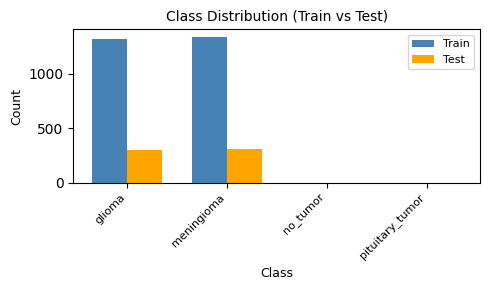

In [30]:
import numpy as np

if df_pred is not None and 'y_true' in df_pred.columns:
    # Single bar (from CSV)
    counts = df_pred['y_true'].value_counts().reindex(CLASSES).fillna(0).astype(int)
    xs, ys = counts.index.tolist(), counts.values.tolist()

    fig, ax = plt.subplots(figsize=(5, 3))  # ukuran kecil
    ax.bar(xs, ys, color='skyblue')
    ax.set_title("Class Distribution (from predictions.csv y_true)", fontsize=10)
    ax.set_xlabel("Class", fontsize=9)
    ax.set_ylabel("Count", fontsize=9)
    ax.tick_params(axis='x', labelrotation=45)
    plt.tight_layout()
    plt.show()

else:
    # Side-by-side: Train & Test
    tr_counts = get_folder_counts(TRAIN_DIR)
    te_counts = get_folder_counts(TEST_DIR)
    xs = np.arange(len(CLASSES))
    ys1 = [tr_counts[c] for c in CLASSES]
    ys2 = [te_counts[c] for c in CLASSES]

    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(5, 3))  # ukuran kecil
    ax.bar(xs - bar_width/2, ys1, width=bar_width, label='Train', color='steelblue')
    ax.bar(xs + bar_width/2, ys2, width=bar_width, label='Test', color='orange')

    ax.set_xticks(xs)
    ax.set_xticklabels(CLASSES, rotation=45, ha='right', fontsize=8)
    ax.set_title("Class Distribution (Train vs Test)", fontsize=10)
    ax.set_xlabel("Class", fontsize=9)
    ax.set_ylabel("Count", fontsize=9)
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


### [Cell 3] Gallery contoh gambar per kelas (3–5 tiap kelas)

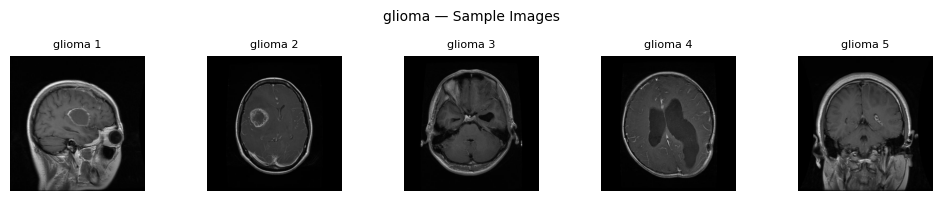

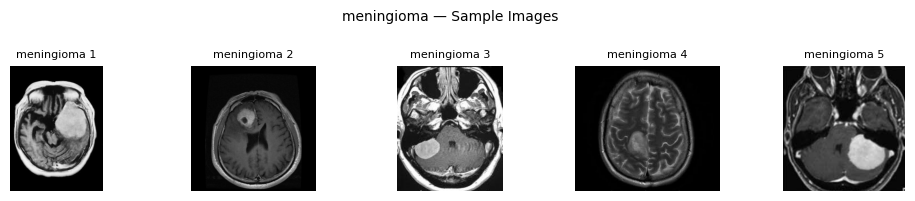

[Info] Tidak ditemukan contoh untuk kelas 'no_tumor'.
[Info] Tidak ditemukan contoh untuk kelas 'pituitary_tumor'.


In [32]:
def sample_paths_for_class(c, k=4):
    # prioritas dari CSV
    if df_pred is not None and 'image_path' in df_pred.columns and 'y_true' in df_pred.columns:
        sub = df_pred[df_pred['y_true'] == c]
        paths = sub['image_path'].dropna().tolist()
    else:
        # fallback ke folder Test (atau Train jika Test kosong)
        base = os.path.join(TEST_DIR, c) if os.path.isdir(os.path.join(TEST_DIR, c)) else os.path.join(TRAIN_DIR, c)
        paths = find_images_in_folder(base)
    random.shuffle(paths)
    return paths[:k]

# Konfigurasi grid
max_cols = 5       # max gambar per baris
img_size = (2, 2)  # ukuran tiap gambar (inch)

for c in CLASSES:
    paths = sample_paths_for_class(c, k=5)
    if not paths:
        print(f"[Info] Tidak ditemukan contoh untuk kelas '{c}'.")
        continue

    n_imgs = len(paths)
    n_cols = min(n_imgs, max_cols)
    n_rows = int(np.ceil(n_imgs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(img_size[0]*n_cols, img_size[1]*n_rows))
    axes = np.array(axes).reshape(-1)  # flatten untuk indexing mudah

    for ax_idx, ax in enumerate(axes):
        if ax_idx < n_imgs:
            img = rgb_imread(paths[ax_idx])
            if img is not None:
                ax.imshow(img)
            ax.set_title(f"{c} {ax_idx+1}", fontsize=8)
        ax.axis('off')

    fig.suptitle(f"{c} — Sample Images", fontsize=10)
    plt.tight_layout()
    plt.show()


### [Cell 4] Distribusi dimensi gambar (width/height)

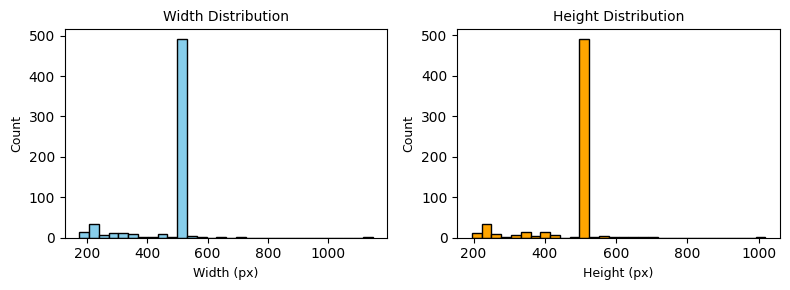

In [34]:
wh = []
if os.path.isdir(TEST_DIR):
    wh.extend(collect_sizes(TEST_DIR, limit=2000))
if not wh and os.path.isdir(TRAIN_DIR):
    wh.extend(collect_sizes(TRAIN_DIR, limit=2000))

if wh:
    ws = [w for w, h in wh]
    hs = [h for w, h in wh]

    # Dua plot berdampingan
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # ukuran kecil
    # Width histogram
    axes[0].hist(ws, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title("Width Distribution", fontsize=10)
    axes[0].set_xlabel("Width (px)", fontsize=9)
    axes[0].set_ylabel("Count", fontsize=9)

    # Height histogram
    axes[1].hist(hs, bins=30, color='orange', edgecolor='black')
    axes[1].set_title("Height Distribution", fontsize=10)
    axes[1].set_xlabel("Height (px)", fontsize=9)
    axes[1].set_ylabel("Count", fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("[Info] Tidak ada gambar untuk menghitung dimensi.")


### [Cell 5] Histogram intensitas grayscale (sampling)

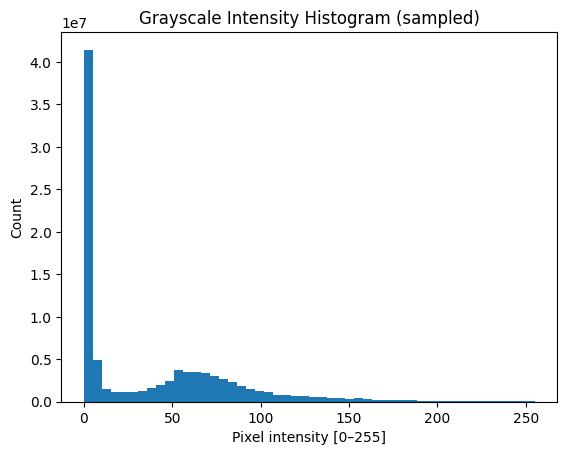

In [35]:
def intensity_histogram(paths, sample=200):
    random.shuffle(paths)
    paths = paths[:sample]
    vals = []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        vals.append(img.flatten())
    if not vals:
        print("[Info] Tidak ada sampel untuk histogram intensitas.")
        return
    V = np.concatenate(vals)
    plt.figure()
    plt.hist(V, bins=50)
    plt.title("Grayscale Intensity Histogram (sampled)")
    plt.xlabel("Pixel intensity [0–255]")
    plt.ylabel("Count")
    plt.show()

all_paths = []
for c in CLASSES:
    # ambil test dulu, kalau kosong ambil train
    base = os.path.join(TEST_DIR, c) if os.path.isdir(os.path.join(TEST_DIR, c)) else os.path.join(TRAIN_DIR, c)
    all_paths.extend(find_images_in_folder(base))
if not all_paths and df_pred is not None and 'image_path' in df_pred.columns:
    all_paths = df_pred['image_path'].dropna().tolist()

if all_paths:
    intensity_histogram(all_paths, sample=400)


### [Cell 6] Showcase augmentasi (original vs augmented)

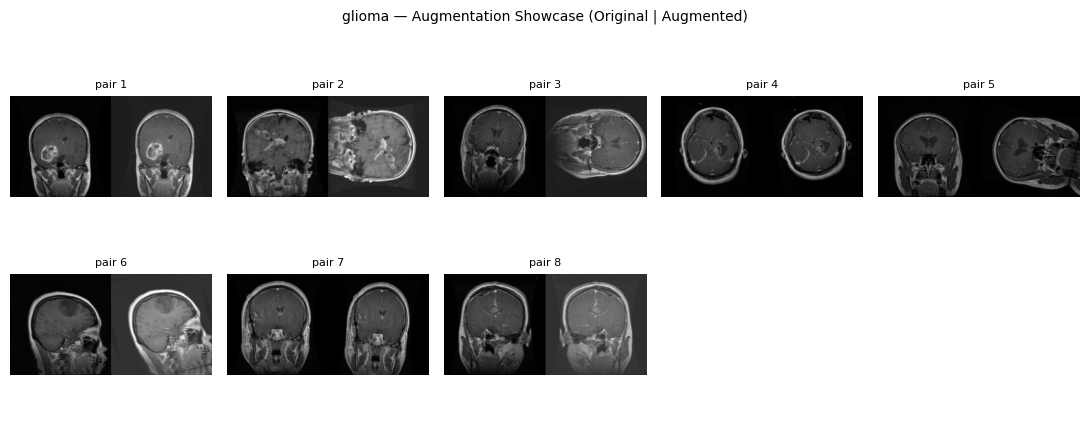

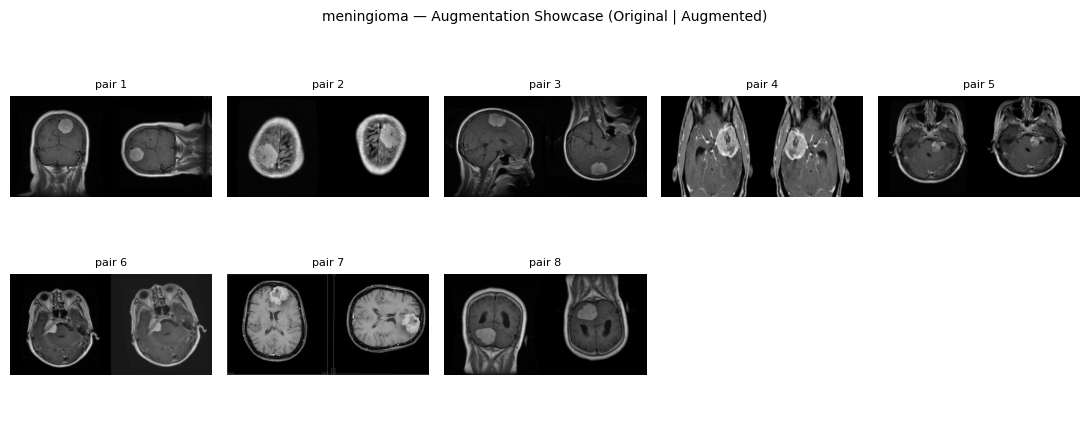

[Info] Tidak ditemukan contoh untuk kelas 'no_tumor'.
[Info] Tidak ditemukan contoh untuk kelas 'pituitary_tumor'.


In [38]:
# --- AUGMENTATION GALLERY: horizontal tiles with wrap ---
try:
    import albumentations as A
    AUG = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
    ])

    def apply_aug(rgb):
        return AUG(image=rgb)['image']

    def make_pair_tile(rgb, aug, tile_size=(160, 160)):
        # resize kedua gambar ke ukuran kecil & gabung mendatar (side-by-side)
        import cv2, numpy as np
        th, tw = tile_size[1], tile_size[0]
        r0 = cv2.resize(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), (tw, th), interpolation=cv2.INTER_AREA)
        r1 = cv2.resize(cv2.cvtColor(aug, cv2.COLOR_RGB2BGR), (tw, th), interpolation=cv2.INTER_AREA)
        pair = cv2.hconcat([r0, r1])  # mendatar
        return cv2.cvtColor(pair, cv2.COLOR_BGR2RGB)

    # Konfigurasi grid
    max_cols = 5         # maks 5 kolom per baris
    k_pairs  = 8         # berapa pasangan per kelas (ubah sesuai kebutuhan)
    tile_w, tile_h = 160, 160  # ukuran kecil per gambar (per sisi)
    # tiap tile = 2 * tile_w lebar karena (original|augmented)

    for c in CLASSES:
        paths = sample_paths_for_class(c, k=k_pairs)
        if not paths:
            print(f"[Info] Tidak ditemukan contoh untuk kelas '{c}'.")
            continue

        # siapkan tiles (original|augmented) per sampel
        tiles = []
        for p in paths:
            img = rgb_imread(p)
            if img is None:
                continue
            aug = apply_aug(img)
            tile = make_pair_tile(img, aug, tile_size=(tile_w, tile_h))
            tiles.append(tile)

        if not tiles:
            print(f"[Info] Tidak ada tile valid untuk kelas '{c}'.")
            continue

        n = len(tiles)
        n_cols = min(n, max_cols)
        n_rows = int(np.ceil(n / n_cols))

        # figure size: lebar mengikuti jumlah kolom, tinggi mengikuti jumlah baris
        # 1 tile lebarnya = 2*tile_w px → skala ke inches kira-kira
        fig_w = n_cols * 2.2   # tweak agar rapih
        fig_h = n_rows * 2.2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
        axes = np.atleast_2d(axes)

        idx = 0
        for r in range(n_rows):
            for ccol in range(n_cols):
                ax = axes[r, ccol]
                if idx < n:
                    ax.imshow(tiles[idx])
                    ax.set_title(f"pair {idx+1}", fontsize=8)
                    idx += 1
                ax.axis('off')

        fig.suptitle(f"{c} — Augmentation Showcase (Original | Augmented)", fontsize=10)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"[Info] Augmentasi dilewati: {e}")


###  [Cell 7] t‑SNE fitur (opsional, butuh model untuk extract embedding)

[OK] Loaded TorchScript: /content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/multitask_resnet18_ts.pt
[Info] Total sampel untuk t‑SNE: 120
[OK] Fitur shape: (120, 4)
[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.258274


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.554840
[t-SNE] KL divergence after 1000 iterations: 0.322389


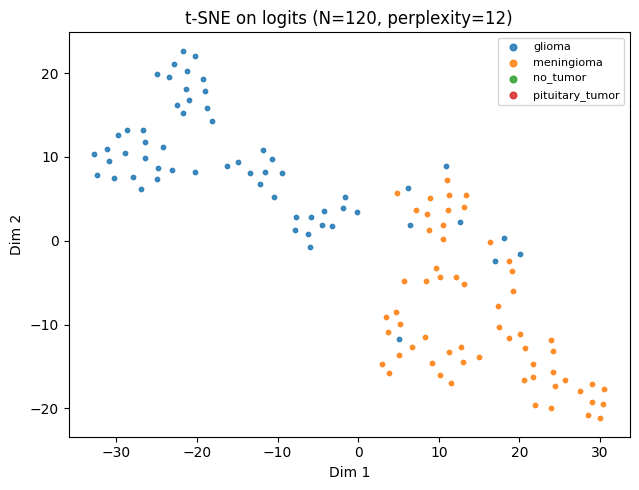

In [41]:
# ===== t-SNE (efisien & minim error) via TorchScript + logits proxy =====
import os, random, gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import pandas as pd

# ---- Paths & Classes ----
DATA_ROOT = os.environ.get("DATA_ROOT", "/content/drive/MyDrive/Prep PhD/Portofolio/Data/MRI_Brain")
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")
CSV_PATH  = os.environ.get("EVAL_CSV", "predictions.csv")

# Samakan label (alias → canonical)
CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary_tumor']
ALIAS = {'notumor': 'no_tumor', 'no tumor':'no_tumor', 'pituitary': 'pituitary_tumor'}

# Model TorchScript (direkomendasikan)
MODEL_PATH = "/content/drive/MyDrive/Prep PhD/Portofolio/brain_mri_project/checkpoints/multitask_resnet18_ts.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def find_images_in_folder(root):
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    out = []
    if os.path.isdir(root):
        for dn,_,fns in os.walk(root):
            for fn in fns:
                if fn.lower().endswith(exts):
                    out.append(os.path.join(dn, fn))
    return out

def rgb_imread(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is None: return None
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# ---- Load TorchScript model ----
if not os.path.exists(MODEL_PATH):
    print(f"[Info] TorchScript model tidak ditemukan di:\n{MODEL_PATH}\n"
          f"→ Ganti MODEL_PATH ke lokasi yang benar atau jalankan export TorchScript dulu.")
    raise SystemExit

model = torch.jit.load(MODEL_PATH, map_location=device)
model.eval()
print(f"[OK] Loaded TorchScript: {MODEL_PATH}")

# ---- Preprocess & feature (logits proxy) ----
def preprocess_rgb(rgb, size=224):
    x = cv2.resize(rgb, (size, size), interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    mean = np.array([0.485,0.456,0.406], np.float32)
    std  = np.array([0.229,0.224,0.225], np.float32)
    x = (x - mean)/std
    x = np.transpose(x, (2,0,1))  # CHW
    return x

@torch.no_grad()
def logits_batch(model, batch_np):  # batch_np: (N,3,224,224) float32
    x = torch.from_numpy(batch_np).to(device)
    out = model(x)
    # Ambil logits sebagai fitur proxy (TorchScript bisa return tensor/list/dict)
    if isinstance(out, dict):
        if 'logits' in out:
            feat = out['logits']
        elif 'features' in out:
            feat = out['features']
        else:
            feat = list(out.values())[0]
    elif isinstance(out, (list, tuple)):
        feat = out[0]
    else:
        feat = out
    return feat.detach().cpu().numpy()

# ---- Kumpulan sampel: prioritas dari CSV, fallback dari folder ----
df_pred = None
if os.path.exists(CSV_PATH):
    try:
        df_pred = pd.read_csv(CSV_PATH)
        if 'y_true' in df_pred.columns:
            df_pred['y_true'] = df_pred['y_true'].astype(str).str.strip().str.lower().replace(ALIAS)
        if 'image_path' in df_pred.columns:
            df_pred['image_path'] = df_pred['image_path'].astype(str)
    except Exception as e:
        print(f"[Info] Gagal baca predictions.csv: {e}")

def sample_paths_for_class(c, k=80):
    # dari CSV
    if df_pred is not None and {'image_path','y_true'}.issubset(df_pred.columns):
        sub = df_pred[df_pred['y_true']==c]['image_path'].dropna().tolist()
        sub = [p for p in sub if os.path.exists(p)]
        random.shuffle(sub)
        if sub: return sub[:k]
    # fallback folder Test lalu Train
    base = os.path.join(TEST_DIR, c) if os.path.isdir(os.path.join(TEST_DIR, c)) else os.path.join(TRAIN_DIR, c)
    files = find_images_in_folder(base)
    random.shuffle(files)
    return files[:k]

# ---- Ambil balanced sample ----
random.seed(42)
per_class = 60            # atur sesuai RAM/Waktu (40–120 bagus)
max_total = 600           # limit total sampel
paths, labels = [], []
for c in CLASSES:
    p = sample_paths_for_class(c, k=per_class)
    n = min(len(p), per_class)
    paths.extend(p[:n]); labels.extend([c]*n)

if len(paths) < len(CLASSES)*10:
    print("[Info] Sampel terlalu sedikit untuk t‑SNE; tambahkan data/CSV.")
    raise SystemExit

# batas total
if len(paths) > max_total:
    idx = np.random.permutation(len(paths))[:max_total]
    paths  = [paths[i] for i in idx]
    labels = [labels[i] for i in idx]

print(f"[Info] Total sampel untuk t‑SNE: {len(paths)}")

# ---- Ekstraksi fitur batched ----
batch_size = 32
features = []
buf = []
for i, p in enumerate(paths, 1):
    rgb = rgb_imread(p)
    if rgb is None:
        continue
    buf.append(preprocess_rgb(rgb))
    if len(buf) == batch_size or i == len(paths):
        arr = np.stack(buf, axis=0).astype(np.float32)  # (B,3,224,224)
        feats = logits_batch(model, arr)                # (B, num_classes) atau (B, D)
        features.append(feats)
        buf.clear()
        # optional: bebaskan memori
        del arr; del feats; gc.collect()

X = np.concatenate(features, axis=0)
Y = np.array(labels)
print(f"[OK] Fitur shape: {X.shape}")

# ---- t-SNE (dengan pre-PCA biar cepat & stabil) ----
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA ke 50 dim atau kurang jika feat dim kecil
pca_dim = min(50, X.shape[1])
Xp = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

# Perplexity diset proporsional jumlah sampel (rule of thumb)
n_samp = Xp.shape[0]
perp = max(5, min(40, n_samp // 10))

tsne = TSNE(n_components=2, perplexity=perp, learning_rate='auto',
            init='pca', random_state=42, n_iter=1000, verbose=1)
Z = tsne.fit_transform(Xp)

# ---- Plot scatter (satu figure) ----
label_to_id = {c:i for i,c in enumerate(CLASSES)}
ids = np.array([label_to_id[y] for y in Y])

plt.figure(figsize=(6.5, 5))
for i,c in enumerate(CLASSES):
    idx = ids==i
    plt.scatter(Z[idx,0], Z[idx,1], s=10, label=c, alpha=0.85)
plt.title(f"t-SNE on logits (N={n_samp}, perplexity={perp})")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()
